# 1. Import and Install Dependencies

In [ ]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib

# นำเข้า Library ที่ใช้

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [ ]:
print(np.__version__)

# 2. Keypoints using MP Holistic
Adapted from https://github.com/nicknochnack/ActionDetectionforSignLanguage

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [5]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

# ทดลองเรียกใช้ OpenCV เพื่อ Capture ท่าทาง ร่างกาย จาก MediaPipe Holistics

In [ ]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
draw_styled_landmarks(frame, results)

In [ ]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [ ]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

## ทดลองนับจำนวนจุดที่ได้บนใบหน้าและท่าทาง

In [ ]:
len(results.face_landmarks.landmark)

In [ ]:
len(results.pose_landmarks.landmark)

In [ ]:
## ทดลองนำจุดบนตำแหน่งของท่าทาง (pose) (33 ตัว) มาใส่ตัวแปร array

In [ ]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [ ]:
print(pose[0])

In [ ]:
print(pose[32])

## กำหนดค่าให้ตัวแปรเพื่อแทนตำแหน่งต่างๆ ของท่าทาง
## ประกอบไปด้วย
#### pose เก็บตำแหน่งของท่าทาง (มีค่าเป็น 0 เมื่อไม่มีตำแหน่งปรากฏ)
#### face เก็บตำแหน่งบนใบหน้า (มีค่าเป็น 0 เมื่อไม่มีตำแหน่งปรากฏ)
#### lh เก็บตำแหน่งบนมือขวา (มีค่าเป็น 0 เมื่อไม่มีตำแหน่งปรากฏ)
#### rh เก็บตำแหน่งบนมือซ้าย (มีค่าเป็น 0 เมื่อไม่มีตำแหน่งปรากฏ)

In [ ]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

#### pose มีตำแหน่ง 33 จุด ดังนั้นตำแหน่งบน array 4 มิติเท่ากับ 33 * 3 = 132 ตัว
### face มีตำแหน่ง 468 จุด ดังนั้นตำแหน่งบน array 3 มิติเท่ากับ 468 * 3 = 1040 ตัว
### lh และ rh มีตำแหน่งข้างละ 21 จุด ดังนั้นตำแหน่งบน array 3 มิติเท่ากับ 21 * 3 = 63 จุด

In [ ]:
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() 
    if results.face_landmarks 
    else np.zeros(1404)


### นำมาเขียนเป็นฟังก์ชันเพื่อแยกจุดออกมาจากการตรวจจับของ Mediapipe ได้ดังนี้

In [6]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

### ทดลองเรียกใช้งานฟังก์ชันโดยส่งรูป ที่เคย capture ไว้

In [ ]:
result_test = extract_keypoints(results)

In [ ]:
result_test.shape

In [ ]:
result_test

In [ ]:
np.save('0', result_test)

In [ ]:
np.load('0.npy')

In [ ]:
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)

In [ ]:
import plotly.graph_objects as go
f = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    f.append(test)
    
f
x,y,z = np.array([f[0][0],f[0][1],f[0][2]])
x,y,z
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers')])
fig.show()

In [ ]:
import plotly.graph_objects as go
import numpy as np

# Helix equation
t = np.linspace(0, 10, 50)
x, y, z = np.cos(t), np.sin(t), t

x,y,z
#fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers')])
#fig.show()

# 4. Setup Folders for Collection

In [7]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect ,'hellofriend','love','me','name','sick','six','you'
#actions = np.array(['feelhot', 'fine','hello'])
#actions = np.array(['hellofriend','love','me'])
#actions = np.array(['one','two','three','four','five'])
#actions = np.array(['six','seven'])
#actions = np.array(['eight','nine'])
##actions = np.array(['ten','hundred'])
actions = np.array(['eight','feelhot','fine','five','four','hello','hellofriend','love','me','nine','one','seven','six','three','two'])


# Fiftheen videos worth of data
no_sequences = 60

# Videos are going to be 30 frames in length
sequence_length = 30


### สร้าง Directory แบบที่หนึ่ง

In [ ]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

### สร้าง Directory แบบที่สอง

In [ ]:
for action in actions: 
    dirmax = np.max(np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int))
    for sequence in range(1,no_sequences+1):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(dirmax+sequence)))
        except:
            pass

# 5. Collect Keypoint Values for Training and Testing

In [ ]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(1000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [8]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [9]:
label_map = {label:num for num, label in enumerate(actions)}

In [ ]:
label_map

### load landmark point from file .npy

In [10]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences): 
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [ ]:
np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int)

In [ ]:
np.array(sequences).shape

In [ ]:
15 * 60 * 30

In [ ]:
np.array(labels).shape

### สร้างตัวแปรสำหรับเตรียม Train

In [11]:
X = np.array(sequences)

In [12]:
X.shape

(900, 30, 1662)

In [ ]:
1662 * 30 * 60 * 15

In [ ]:
180 * 30 * 1662

# onehot encoding

In [13]:
y = to_categorical(labels).astype(int)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [15]:
y_test.shape

(180, 15)

In [16]:
X_train.shape

(720, 30, 1662)

In [17]:
y_train.shape

(720, 15)

In [ ]:
X_test.shape

# 7. Build and Train LSTM Neural Network

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [19]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [ ]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=1000, callbacks=[tb_callback])

In [ ]:
model.summary()

In [ ]:
plt.plot(history.history['categorical_accuracy'])
#plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
print(history.history.keys())

# 8. Make Predictions

In [ ]:
res = model.predict(X_test)

In [ ]:
actions[np.argmax(res[4])]

In [ ]:
actions[np.argmax(y_test[4])]

# 9. Save Weights

In [ ]:
model.save('tsl-action-v3.h5')

In [ ]:
del model

In [ ]:
model.load_weights('tsl-action-v2.h5')

# 10. Evaluation using Confusion Matrix and Accuracy

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [ ]:
yhat = model.predict(X_test)

In [ ]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
multilabel_confusion_matrix(ytrue, yhat)

In [ ]:
accuracy_score(ytrue, yhat)

# 11. Test in Real Time

In [ ]:
from scipy import stats

In [ ]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [ ]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

# Build Multiple Model for compare

In [20]:
def build_model_lstm(label):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(128, return_sequences=True,
                   input_shape=(X_train.shape[1], X_train.shape[2]))) 
    model.add(tf.keras.layers.LSTM(192, return_sequences=True))
    model.add(tf.keras.layers.LSTM(64, return_sequences=True))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.LSTM(128))
    model.add(tf.keras.layers.Dense(label, activation='softmax'))
    model.compile(
        loss=tf.keras.losses.categorical_crossentropy,
        #loss=tf.keras.losses.binary_crossentropy,
        optimizer=tf.keras.optimizers.Adamax(),
        metrics=['accuracy'])
    return model

In [21]:
def build_model_bdlstm(label):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True),
                   input_shape=(X_train.shape[1], X_train.shape[2])))
    
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)))
    #model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
    model.add(tf.keras.layers.Dense(label, activation='softmax'))
    model.compile(
        loss=tf.keras.losses.categorical_crossentropy,
        #loss=tf.keras.losses.binary_crossentropy,
        optimizer=tf.keras.optimizers.RMSprop(),
        metrics=['accuracy'])
    return model

In [22]:
def build_model_gru(label):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.GRU(192, return_sequences=True,
                   input_shape=(X_train.shape[1], X_train.shape[2]))) 
    model.add(tf.keras.layers.GRU(192, return_sequences=True))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.GRU(32))
    model.add(tf.keras.layers.Dense(label, activation='softmax'))
    model.compile(
        loss=tf.keras.losses.categorical_crossentropy,
        #loss=tf.keras.losses.binary_crossentropy,
        optimizer=tf.keras.optimizers.Adamax(),
        metrics=['accuracy'])
    return model

In [23]:
import tensorflow as tf

model_lstm=build_model_lstm(actions.shape[0])
model_bdlstm=build_model_bdlstm(actions.shape[0])
model_gru=build_model_gru(actions.shape[0])


# train lstm model

batch size is the number of samples for each iteration that you feed to your model.
For example, if you have a dataset that has 10,000 samples and you use a batch-size of 100, then it will take 10,000 / 100 = 100 iterations to reach an epoch.

What you see in your log is the number of epochs and the number of iterations.
Epoch 160/170 denotes that you are currently running epoch 160 out of a total 170 epochs. Each epoch of yours takes 32 iterations.

knowing that your samples are only 3,459, each batch-size would be 3459 / 32 = 108.

In [25]:
#from pandas import DataFrame
#train_lstm_loss = DataFrame()
#val_lstm_loss = DataFrame()
#score_lstm = DataFrame()
#acc_lstm = DataFrame()

my_callbacks_lstm = [
        #tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30),
        tf.keras.callbacks.ModelCheckpoint('best_model_lstm-v2.h5', monitor='val_loss', mode='min', save_best_only=True,verbouse = 1),
        tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    ]
#X_train, X_test, y_train, y_test
#for i in range(5):
    #dirname="/Users/anusorn/Desktop/TSl/outputvideo/landmark/Absolute/"
    #x_train,y_train,x_test,y_test=load_data(dirname)
    #model_lstm=build_model_lstm(y_train.shape[1])
history_lstm=model_lstm.fit(
    X_train,y_train,
    epochs=300,
    batch_size=16,
    validation_data=(X_test,y_test),
    validation_split=0.3,
    #callbacks = my_callbacks_lstm,
    verbose=1
)

 

Epoch 1/300
32/32 [==============================] - 11s 196ms/step - loss: 2.7377 - accuracy: 0.0861 - val_loss: 2.7074 - val_accuracy: 0.0553
Epoch 2/300
32/32 [==============================] - 4s 118ms/step - loss: 2.6092 - accuracy: 0.0991 - val_loss: 2.2369 - val_accuracy: 0.1336
Epoch 3/300
32/32 [==============================] - 3s 87ms/step - loss: 2.3025 - accuracy: 0.1266 - val_loss: 2.1699 - val_accuracy: 0.2581
Epoch 4/300
32/32 [==============================] - 3s 89ms/step - loss: 2.1528 - accuracy: 0.1881 - val_loss: 2.0303 - val_accuracy: 0.1751
Epoch 5/300
32/32 [==============================] - 3s 96ms/step - loss: 1.9717 - accuracy: 0.2523 - val_loss: 2.2353 - val_accuracy: 0.2258
Epoch 6/300
32/32 [==============================] - 3s 96ms/step - loss: 2.1161 - accuracy: 0.2235 - val_loss: 1.7986 - val_accuracy: 0.3226
Epoch 7/300
32/32 [==============================] - 3s 88ms/step - loss: 1.8099 - accuracy: 0.3384 - val_loss: 1.7538 - val_accuracy: 0.3410
Epo

Epoch 115/300
32/32 [==============================] - 3s 106ms/step - loss: 0.3707 - accuracy: 0.8562 - val_loss: 0.6584 - val_accuracy: 0.7742
Epoch 116/300
32/32 [==============================] - 3s 106ms/step - loss: 0.4926 - accuracy: 0.7983 - val_loss: 0.6515 - val_accuracy: 0.7558
Epoch 117/300
32/32 [==============================] - 4s 111ms/step - loss: 0.3684 - accuracy: 0.8388 - val_loss: 0.8898 - val_accuracy: 0.6590
Epoch 118/300
32/32 [==============================] - 4s 110ms/step - loss: 0.4770 - accuracy: 0.8046 - val_loss: 0.5631 - val_accuracy: 0.8203
Epoch 119/300
32/32 [==============================] - 3s 109ms/step - loss: 0.3162 - accuracy: 0.8940 - val_loss: 0.5070 - val_accuracy: 0.8111
Epoch 120/300
32/32 [==============================] - 4s 112ms/step - loss: 0.3714 - accuracy: 0.8430 - val_loss: 0.4863 - val_accuracy: 0.8341
Epoch 121/300
32/32 [==============================] - 3s 110ms/step - loss: 0.3244 - accuracy: 0.8764 - val_loss: 0.5404 - val_ac

32/32 [==============================] - 4s 116ms/step - loss: 0.2938 - accuracy: 0.8609 - val_loss: 0.5335 - val_accuracy: 0.8203
Epoch 228/300
32/32 [==============================] - 4s 116ms/step - loss: 0.2066 - accuracy: 0.9230 - val_loss: 0.4573 - val_accuracy: 0.8479
Epoch 229/300
32/32 [==============================] - 4s 112ms/step - loss: 0.1484 - accuracy: 0.9407 - val_loss: 0.5569 - val_accuracy: 0.8341
Epoch 230/300
32/32 [==============================] - 4s 127ms/step - loss: 0.1517 - accuracy: 0.9464 - val_loss: 0.5355 - val_accuracy: 0.8341
Epoch 231/300
32/32 [==============================] - 4s 123ms/step - loss: 0.1471 - accuracy: 0.9533 - val_loss: 0.7618 - val_accuracy: 0.7650
Epoch 232/300
32/32 [==============================] - 4s 113ms/step - loss: 0.3219 - accuracy: 0.8804 - val_loss: 1.0091 - val_accuracy: 0.6820
Epoch 233/300
32/32 [==============================] - 4s 112ms/step - loss: 0.3635 - accuracy: 0.8682 - val_loss: 0.6247 - val_accuracy: 0.8065

# train bdlstm model

In [27]:
my_callbacks_blstm = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50),
        tf.keras.callbacks.ModelCheckpoint('best_model_bdlstm.h5', monitor='val_loss', mode='min', save_best_only=True,verbouse = 1),
        tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    ]

history_bdlstm=model_bdlstm.fit(
    X_train,y_train,
    epochs=1000,
    batch_size=16,
    validation_data=(X_test,y_test),
    validation_split=0.3,
    callbacks = my_callbacks_blstm,
    verbose=1
)
score_blstm, acc_blstm = model_bdlstm.evaluate(X_test,y_test,batch_size=16,verbose=0)
print('Test performance BLSTM: accuracy={0}, loss={1}'.format(acc_blstm, score_blstm))
 

Epoch 1/1000
32/32 [==============================] - 17s 276ms/step - loss: 2.8364 - accuracy: 0.0799 - val_loss: 2.7380 - val_accuracy: 0.0783
Epoch 2/1000
32/32 [==============================] - 6s 181ms/step - loss: 2.7440 - accuracy: 0.0514 - val_loss: 2.7760 - val_accuracy: 0.0645
Epoch 3/1000
32/32 [==============================] - 6s 183ms/step - loss: 2.7386 - accuracy: 0.0778 - val_loss: 2.7466 - val_accuracy: 0.0691
Epoch 4/1000
32/32 [==============================] - 6s 193ms/step - loss: 2.5440 - accuracy: 0.1363 - val_loss: 2.6757 - val_accuracy: 0.0783
Epoch 5/1000
32/32 [==============================] - 6s 193ms/step - loss: 2.3468 - accuracy: 0.1291 - val_loss: 2.1072 - val_accuracy: 0.2350
Epoch 6/1000
32/32 [==============================] - 6s 193ms/step - loss: 2.0858 - accuracy: 0.2070 - val_loss: 1.9206 - val_accuracy: 0.2857
Epoch 7/1000
32/32 [==============================] - 6s 192ms/step - loss: 2.0425 - accuracy: 0.2577 - val_loss: 1.9701 - val_accuracy

32/32 [==============================] - 7s 210ms/step - loss: 0.2689 - accuracy: 0.9067 - val_loss: 1.0959 - val_accuracy: 0.6820
Epoch 114/1000
32/32 [==============================] - 6s 203ms/step - loss: 0.3566 - accuracy: 0.8698 - val_loss: 0.9077 - val_accuracy: 0.7558
Epoch 115/1000
32/32 [==============================] - 7s 210ms/step - loss: 0.3284 - accuracy: 0.8714 - val_loss: 0.8036 - val_accuracy: 0.7604
Epoch 116/1000
32/32 [==============================] - 7s 206ms/step - loss: 0.3032 - accuracy: 0.8968 - val_loss: 0.8143 - val_accuracy: 0.7558
Epoch 117/1000
32/32 [==============================] - 7s 210ms/step - loss: 0.2307 - accuracy: 0.9209 - val_loss: 0.8879 - val_accuracy: 0.7373
Epoch 118/1000
32/32 [==============================] - 7s 209ms/step - loss: 0.5118 - accuracy: 0.8328 - val_loss: 1.7359 - val_accuracy: 0.5714
Epoch 119/1000
32/32 [==============================] - 7s 234ms/step - loss: 0.3720 - accuracy: 0.8847 - val_loss: 0.8799 - val_accuracy: 

# train gru

In [31]:
my_callbacks_gru = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50),
        tf.keras.callbacks.ModelCheckpoint('best_model_gru.h5', monitor='val_loss', mode='min', save_best_only=True,verbouse = 1),
        tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    ]

history_gru=model_gru.fit(
    X_train,y_train,
    epochs=1000,
    batch_size=16,
    validation_data=(X_test,y_test),
    validation_split=0.3,
    callbacks = my_callbacks_gru,
    verbose=1
)

Epoch 1/1000
32/32 [==============================] - 8s 136ms/step - loss: 2.9355 - accuracy: 0.0450 - val_loss: 2.7311 - val_accuracy: 0.0645
Epoch 2/1000
32/32 [==============================] - 3s 98ms/step - loss: 2.7141 - accuracy: 0.0525 - val_loss: 2.6635 - val_accuracy: 0.2673
Epoch 3/1000
32/32 [==============================] - 3s 101ms/step - loss: 2.6366 - accuracy: 0.1591 - val_loss: 2.5184 - val_accuracy: 0.2442
Epoch 4/1000
32/32 [==============================] - 3s 99ms/step - loss: 2.4599 - accuracy: 0.2454 - val_loss: 2.2435 - val_accuracy: 0.2488
Epoch 5/1000
32/32 [==============================] - 3s 101ms/step - loss: 2.2159 - accuracy: 0.2661 - val_loss: 2.1009 - val_accuracy: 0.2949
Epoch 6/1000
32/32 [==============================] - 3s 101ms/step - loss: 2.0699 - accuracy: 0.3418 - val_loss: 2.1187 - val_accuracy: 0.2765
Epoch 7/1000
32/32 [==============================] - 3s 102ms/step - loss: 1.9759 - accuracy: 0.3311 - val_loss: 1.8864 - val_accuracy: 0

32/32 [==============================] - 3s 105ms/step - loss: 0.1843 - accuracy: 0.9427 - val_loss: 0.3771 - val_accuracy: 0.8940
Epoch 114/1000
32/32 [==============================] - 3s 104ms/step - loss: 0.1691 - accuracy: 0.9342 - val_loss: 0.4398 - val_accuracy: 0.8710
Epoch 115/1000
32/32 [==============================] - 3s 105ms/step - loss: 0.3126 - accuracy: 0.8819 - val_loss: 0.4694 - val_accuracy: 0.8756
Epoch 116/1000
32/32 [==============================] - 3s 106ms/step - loss: 0.1981 - accuracy: 0.9314 - val_loss: 0.8672 - val_accuracy: 0.7281
Epoch 117/1000
32/32 [==============================] - 3s 107ms/step - loss: 0.4310 - accuracy: 0.8241 - val_loss: 0.5645 - val_accuracy: 0.8157
Epoch 118/1000
32/32 [==============================] - 3s 105ms/step - loss: 0.3548 - accuracy: 0.8637 - val_loss: 0.5215 - val_accuracy: 0.8479
Epoch 119/1000
32/32 [==============================] - 3s 107ms/step - loss: 0.2545 - accuracy: 0.8872 - val_loss: 0.3963 - val_accuracy: 

32/32 [==============================] - 3s 104ms/step - loss: 0.1103 - accuracy: 0.9641 - val_loss: 0.3469 - val_accuracy: 0.9217
Epoch 226/1000
32/32 [==============================] - 3s 105ms/step - loss: 0.0642 - accuracy: 0.9804 - val_loss: 0.3877 - val_accuracy: 0.9032
Epoch 227/1000
32/32 [==============================] - 4s 111ms/step - loss: 0.0938 - accuracy: 0.9675 - val_loss: 0.3826 - val_accuracy: 0.9124
Epoch 228/1000
32/32 [==============================] - 3s 104ms/step - loss: 0.0571 - accuracy: 0.9926 - val_loss: 0.4906 - val_accuracy: 0.8756
Epoch 229/1000
32/32 [==============================] - 3s 106ms/step - loss: 0.0559 - accuracy: 0.9797 - val_loss: 0.3957 - val_accuracy: 0.8848
Epoch 230/1000
32/32 [==============================] - 3s 105ms/step - loss: 0.0980 - accuracy: 0.9662 - val_loss: 0.3746 - val_accuracy: 0.8986
Epoch 231/1000
32/32 [==============================] - 3s 105ms/step - loss: 0.0767 - accuracy: 0.9782 - val_loss: 0.5691 - val_accuracy: 

In [ ]:
history_lstm.history.keys()


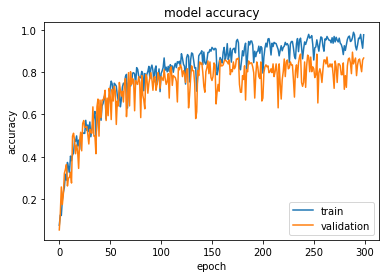

In [26]:
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

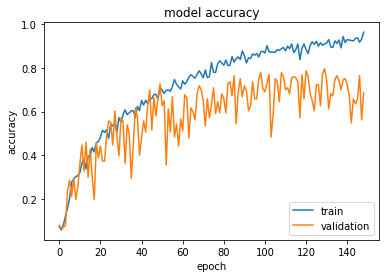

In [28]:
plt.plot(history_bdlstm.history['accuracy'])
plt.plot(history_bdlstm.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

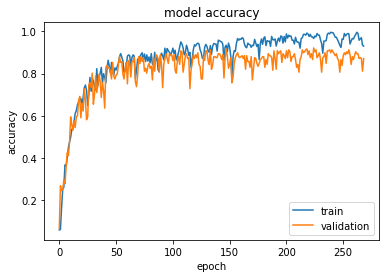

In [32]:
plt.plot(history_gru.history['accuracy'])
plt.plot(history_gru.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

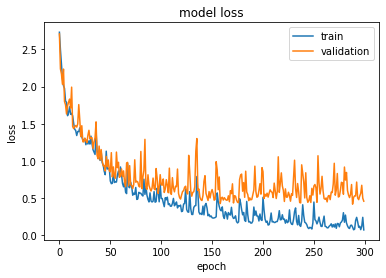

In [29]:
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

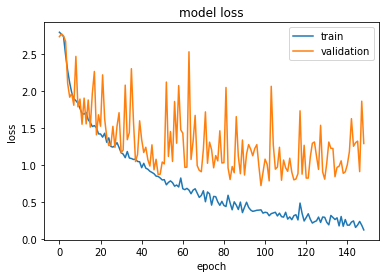

In [30]:
plt.plot(history_bdlstm.history['loss'])
plt.plot(history_bdlstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

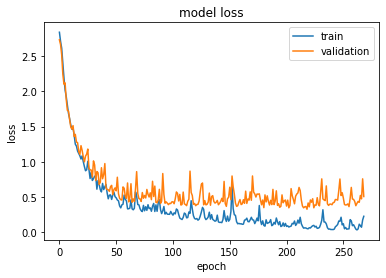

In [33]:
plt.plot(history_gru.history['loss'])
plt.plot(history_gru.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [34]:
model_lstm.save('tsl-lstm-action-v6.h5')

In [35]:
model_bdlstm.save('tsl-bdlstm-action-v6.h5')

In [36]:
model_gru.save('tsl-gru-action-v6.h5')

In [37]:
import tensorflow as tf

In [38]:
new_model_lstm = tf.keras.models.load_model('tsl-lstm-action-v5.h5')
score_lstm, acc_lstm = new_model_lstm.evaluate(X_test,y_test,batch_size=16,verbose=0)
print('Test performance lstm: accuracy={0}, loss={1}'.format(acc_lstm, score_lstm))

Test performance lstm: accuracy=0.9333333373069763, loss=0.2266474813222885


In [39]:
new_model_bdlstm = tf.keras.models.load_model('tsl-bdlstm-action-v5.h5')
score_lstm, acc_lstm = new_model_bdlstm.evaluate(X_test,y_test,batch_size=16,verbose=0)
print('Test performance lstm: accuracy={0}, loss={1}'.format(acc_lstm, score_lstm))

Test performance lstm: accuracy=0.8999999761581421, loss=0.43287357687950134


In [40]:
new_model_gru = tf.keras.models.load_model('tsl-gru-action-v5.h5')
score_lstm, acc_lstm = new_model_gru.evaluate(X_test,y_test,batch_size=16,verbose=0)
print('Test performance lstm: accuracy={0}, loss={1}'.format(acc_lstm, score_lstm))

Test performance lstm: accuracy=0.9611111283302307, loss=0.13453741371631622


In [41]:
new_model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 128)           916992    
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 192)           246528    
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 64)            65792     
_________________________________________________________________
dropout (Dropout)            (None, 30, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 15)                1935      
Total params: 1,330,063
Trainable params: 1,330,063
Non-trainable params: 0
______________________________________________

In [42]:
new_model_bdlstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 30, 256)           1833984   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 30, 256)           394240    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 30, 256)           394240    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense_1 (Dense)              (None, 15)                1935      
Total params: 2,788,751
Trainable params: 2,788,751
Non-trainable params: 0
_________________________________________________________________


In [43]:
new_model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 30, 192)           1069056   
_________________________________________________________________
gru_1 (GRU)                  (None, 30, 192)           222336    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 192)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                21696     
_________________________________________________________________
dense_2 (Dense)              (None, 15)                495       
Total params: 1,313,583
Trainable params: 1,313,583
Non-trainable params: 0
_________________________________________________________________


# plot matrix

In [44]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=12)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize = 12)
    plt.yticks(tick_marks, classes, fontsize = 12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 10)

    plt.tight_layout()
    plt.ylabel('True label', fontsize = 8)
    plt.xlabel('Predicted label', fontsize = 8)

# Plot confusion matrix for lstm

Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.07142857 0.92857143 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.85714286 0.14285714 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.0625     0.9375     0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0

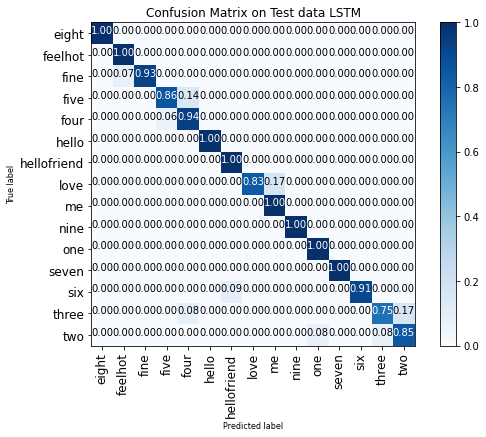

<Figure size 432x288 with 0 Axes>

In [45]:
from sklearn.metrics import confusion_matrix
import itertools

xhat_lstm = X_test
yhat_lstm = new_model_lstm.predict(xhat_lstm)


cfm_lstm = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(yhat_lstm, axis=1))

plt.figure(figsize=(8,6))
class_names = actions

plot_confusion_matrix(cfm_lstm, classes=class_names, normalize = True,title='Confusion Matrix on Test data LSTM')
plt.show()
plt.tight_layout()

Normalized confusion matrix
[[0.83333333 0.         0.         0.         0.08333333 0.
  0.         0.         0.         0.08333333 0.         0.
  0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.57142857 0.35714286 0.
  0.         0.         0.         0.         0.         0.
  0.         0.07142857 0.        ]
 [0.         0.         0.         0.         0.9375     0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.0625    ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0

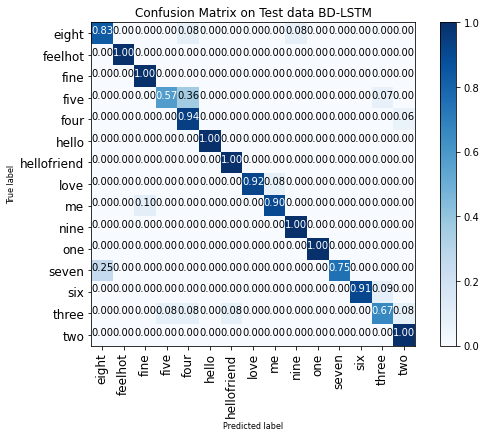

<Figure size 432x288 with 0 Axes>

In [46]:
from sklearn.metrics import confusion_matrix
import itertools

xhat_bdlstm = X_test
yhat_bdlstm = new_model_bdlstm.predict(xhat_bdlstm)


cfm_bdlstm = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(yhat_bdlstm, axis=1))

plt.figure(figsize=(8,6))
class_names = actions

plot_confusion_matrix(cfm_bdlstm, classes=class_names, normalize = True,title='Confusion Matrix on Test data BD-LSTM')
plt.show()
plt.tight_layout()

Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.85714286 0.14285714 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.125      0.875      0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0

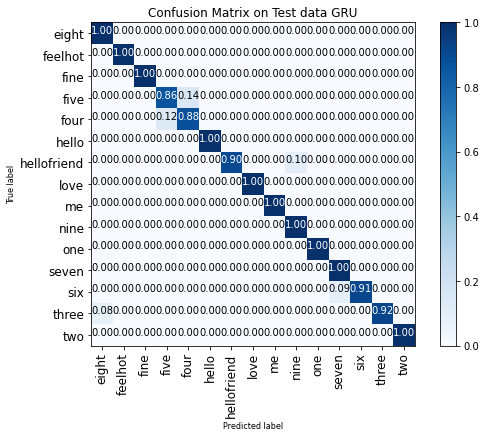

<Figure size 432x288 with 0 Axes>

In [47]:
from sklearn.metrics import confusion_matrix
import itertools

xhat_gru = X_test
yhat_gru = new_model_gru.predict(xhat_gru)


cfm_gru = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(yhat_gru, axis=1))

plt.figure(figsize=(8,6))
class_names = actions

plot_confusion_matrix(cfm_gru, classes=class_names, normalize = True,title='Confusion Matrix on Test data GRU')
plt.show()
plt.tight_layout()

# test new model from loaded model

In [ ]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        
        # Test Model
        if len(sequence) == 30:
            res = new_model_gru.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()